# RapidoPGS-single

This package requires GWAS data in a specific format and uses that file to recalculate betas and produce a new GWAS with updated betas, which can be directly used with PLINK for execution.

It requires R >= 4.3

```bash
conda activate advanceR
```

GitHub repository: [GRealesM/RapidoPGS](https://github.com/GRealesM/RapidoPGS)

If the `BiocManager` package is not already installed, use the following commands:

```r
if (!requireNamespace("BiocManager", quietly = TRUE)) {
    install.packages("BiocManager")
}
BiocManager::install("GenomicRanges")
```

Install the RapidoPGS package:

```r
install.packages("RapidoPGS")
```

For the development version:

```r
install.packages("remotes")
library(remotes)
install.packages('R.utils')
install_github('GRealesM/RapidoPGS')
```

The package accepts the GWAS data frame, the trait (`"cc"` for binary or `"quant"` for continuous), and the build (`"hg38"` or `"hg19"`). Additionally, for continuous phenotypes, specify the number of people required.

Example usage:

```r
full_PGS <- rapidopgs_single(ds, trait = traittype, build = build, N = n)
```

Documentation: [RapidoPGS Documentation](https://grealesm.github.io/RapidoPGS/articles/Computing_RapidoPGSmulti.html)



### RapidoPGS-single.R File
```r
library(RapidoPGS)



#1. Argument one is the Directory Example: `SampleData1`
#2. Argument two is the GWASfile Example: `SampleData1/SampleData1.txt`
#3. Argument three is the built. Example: `hg38` or `hg19`
#4. Argument 4 is the traittype Example: `cc` for binary  or `quant` for continous.
#5. Argument 5 is the niumber of people for required for continous phenotypes.


# Read the GWAS data file
args <- commandArgs(trailingOnly = TRUE)
directory <- args[1] 
gwasfile <- args[2]
build <- args[3]
traittype <- args[4]
n <- args[5]
print(directory)
print(gwasfile)
print(build)


ds <- read.table(gwasfile, header = TRUE, sep = "\t", stringsAsFactors = FALSE)
ds <- as.data.frame(ds)
print(names(ds))
print(data.frame(Column = 1:length(names(ds)), Name = names(ds)))
print(head(ds))
print(class(ds))


# Ensure required columns are present
required_columns <- c("CHR", "BP", "SNPID", "REF", "ALT","N", "ALT_FREQ", "BETA", "SE", "P")
 
# Subset relevant columns and remove non-autosomal chromosomes
ds <- ds[, c("SNPID", "CHR", "BP", "REF", "ALT", "N","ALT_FREQ", "BETA", "SE", "P")]
print(nrow(ds))
# Remove non-autosomal chromosomes
ds <- ds[ds$CHR != "X", ]
print(nrow(ds))
# Convert CHR to numeric
ds$CHR <- as.numeric(ds$CHR)
print(nrow(ds))
# Order by CHR and BP
ds <- ds[order(ds$CHR, ds$BP), ]
print(nrow(ds)) 
# Remove rows with NA in BETA or ALT_FREQ
ds<- ds[!is.na(ds$BETA) & !is.na(ds$ALT_FREQ), ]
print(nrow(ds))

# Compute the polygenic score
full_PGS <- rapidopgs_single(ds, trait = traittype , build = build,N=as.numeric(n))

# Print the result
print(head(full_PGS))

# Save the result to a file
 
result <-paste(".",args[1],"RapidoPGS-single.txt",sep="//")

if (file.exists(result)) {
file.remove(result)
print(paste("File", result, "deleted."))
}
 
write.table(full_PGS, file = result, sep = "\t", row.names = FALSE, quote = FALSE)


```

## GWAS File Processing for RapidoPGS-single

The package requires betas for calculation. For odds ratios (OR), convert OR to betas using the log transformation and update the standard error (SE) as well:

```python
df["BETA"] = np.log(df["OR"])
df["SE"] = df["SE"] / df["OR"]
```

**Column Descriptions:**

- **CHR:** Chromosome
- **BP:** Base position (in GRCh37/hg19 or GRCh38/hg38). Use `build = “hg38”` in parameters if using hg38.
- **SNPID:** rsids, or SNP identifiers. If not available, they can be anything (e.g., CHR_BP).
- **REF:** Reference, or non-effect allele
- **ALT:** Alternative, or effect allele, the one being referred to
- **BETA:** β (or log(OR)), or effect sizes
- **SE:** Standard error of β
- **P:** P-values for the association test
```


In [1]:
import os
import pandas as pd
import numpy as np

#filedirec = sys.argv[1]

filedirec = "SampleData1"
#filedirec = "asthma_19"
#filedirec = "migraine_0"

def check_phenotype_is_binary_or_continous(filedirec):
    # Read the processed quality controlled file for a phenotype
    df = pd.read_csv(filedirec+os.sep+filedirec+'_QC.fam',sep="\s+",header=None)
    column_values = df[5].unique()
 
    if len(set(column_values)) == 2:
        return "Binary"
    else:
        return "Continous"



# Read the GWAS file.
GWAS = filedirec + os.sep + filedirec+".gz"
df = pd.read_csv(GWAS,compression= "gzip",sep="\s+")
 

 
if "BETA" in df.columns.to_list():
    # For Continous Phenotype.
    df = df[['CHR', 'BP', 'SNP', 'A1', 'A2', 'N', 'SE', 'P', 'BETA', 'INFO', 'MAF']]

else:
    df["BETA"] = np.log(df["OR"])
    df["SE"] = df["SE"]/df["OR"]
    df = df[['CHR', 'BP', 'SNP', 'A1', 'A2', 'N', 'SE', 'P', 'BETA', 'INFO', 'MAF']]


    
df = df.rename(columns={
    'CHR': 'CHR',
    'BP': 'BP',
    'SNP': 'SNPID',
    'A1': 'ALT',    
    'A2': 'REF',
    'N': 'N',           # Note: This is not required for RápidoPGS but may be in your original data
    'SE': 'SE',
    'P': 'P',
    'BETA': 'BETA',
    'INFO': 'INFO',     # Note: This is not required for RápidoPGS but may be in your original data
    'MAF': 'ALT_FREQ'   #  'MAF' corresponds to 'ALT_FREQ'
})

numberofpeople = df['N'].mean()
# Remove unnecessary columns (if needed)
df = df[['CHR', 'BP', 'SNPID', 'REF','N', 'ALT', 'ALT_FREQ', 'BETA', 'SE', 'P']]
 
  


df.to_csv(filedirec + os.sep +filedirec+"_rapido_single.txt",sep="\t",index=False)
print(df.head().to_markdown())
print("Length of DataFrame!",len(df))


|    |   CHR |     BP | SNPID      | REF   |      N | ALT   |   ALT_FREQ |        BETA |         SE |        P |
|---:|------:|-------:|:-----------|:------|-------:|:------|-----------:|------------:|-----------:|---------:|
|  0 |     1 | 756604 | rs3131962  | G     | 388028 | A     |   0.36939  | -0.00211532 | 0.00302305 | 0.483171 |
|  1 |     1 | 768448 | rs12562034 | G     | 388028 | A     |   0.336846 |  0.00068708 | 0.00329246 | 0.834808 |
|  2 |     1 | 779322 | rs4040617  | A     | 388028 | G     |   0.377368 | -0.00239932 | 0.00304073 | 0.42897  |
|  3 |     1 | 801536 | rs79373928 | T     | 388028 | G     |   0.483212 |  0.00203363 | 0.00839615 | 0.808999 |
|  4 |     1 | 808631 | rs11240779 | A     | 388028 | G     |   0.45041  |  0.00130747 | 0.00242504 | 0.590265 |
Length of DataFrame! 499617


### Define Hyperparameters

Define hyperparameters to be optimized and set initial values.

### Extract Valid SNPs from Clumped File

For Windows, download `gwak`, and for Linux, the `awk` command is sufficient. For Windows, `GWAK` is required. You can download it from [here](https://sourceforge.net/projects/gnuwin32/). Get it and place it in the same directory.


### Execution Path

At this stage, we have the genotype training data `newtrainfilename = "train_data.QC"` and genotype test data `newtestfilename = "test_data.QC"`.

We modified the following variables:

1. `filedirec = "SampleData1"` or `filedirec = sys.argv[1]`
2. `foldnumber = "0"` or `foldnumber = sys.argv[2]` for HPC.

Only these two variables can be modified to execute the code for specific data and specific folds. Though the code can be executed separately for each fold on HPC and separately for each dataset, it is recommended to execute it for multiple diseases and one fold at a time.
Here’s the corrected text in Markdown format:

 
### P-values

PRS calculation relies on P-values. SNPs with low P-values, indicating a high degree of association with a specific trait, are considered for calculation.

You can modify the code below to consider a specific set of P-values and save the file in the same format.

We considered the following parameters:

- **Minimum P-value**: `1e-10`
- **Maximum P-value**: `1.0`
- **Minimum exponent**: `10`  (Minimum P-value in exponent)
- **Number of intervals**: `100`  (Number of intervals to be considered)

The code generates an array of logarithmically spaced P-values:

```python
import numpy as np
import os

minimumpvalue = 10  # Minimum exponent for P-values
numberofintervals = 100  # Number of intervals to be considered

allpvalues = np.logspace(-minimumpvalue, 0, numberofintervals, endpoint=True)  # Generating an array of logarithmically spaced P-values

print("Minimum P-value:", allpvalues[0])
print("Maximum P-value:", allpvalues[-1])

count = 1
with open(os.path.join(folddirec, 'range_list'), 'w') as file:
    for value in allpvalues:
        file.write(f'pv_{value} 0 {value}\n')  # Writing range information to the 'range_list' file
        count += 1

pvaluefile = os.path.join(folddirec, 'range_list')
```

In this code:
- `minimumpvalue` defines the minimum exponent for P-values.
- `numberofintervals` specifies how many intervals to consider.
- `allpvalues` generates an array of P-values spaced logarithmically.
- The script writes these P-values to a file named `range_list` in the specified directory.
 

In [2]:
from operator import index
import pandas as pd
import numpy as np
import os
import subprocess
import sys
import pandas as pd
import statsmodels.api as sm
import pandas as pd
from sklearn.metrics import roc_auc_score, confusion_matrix
from statsmodels.stats.contingency_tables import mcnemar

def create_directory(directory):
    """Function to create a directory if it doesn't exist."""
    if not os.path.exists(directory):  # Checking if the directory doesn't exist
        os.makedirs(directory)  # Creating the directory if it doesn't exist
    return directory  # Returning the created or existing directory

 
#foldnumber = sys.argv[1]
foldnumber = "0"  # Setting 'foldnumber' to "0"

folddirec = filedirec + os.sep + "Fold_" + foldnumber  # Creating a directory path for the specific fold
trainfilename = "train_data"  # Setting the name of the training data file
newtrainfilename = "train_data.QC"  # Setting the name of the new training data file

testfilename = "test_data"  # Setting the name of the test data file
newtestfilename = "test_data.QC"  # Setting the name of the new test data file

# Number of PCA to be included as a covariate.
numberofpca = ["6"]  # Setting the number of PCA components to be included

# Clumping parameters.
clump_p1 = [1]  # List containing clump parameter 'p1'
clump_r2 = [0.1]  # List containing clump parameter 'r2'
clump_kb = [200]  # List containing clump parameter 'kb'

# Pruning parameters.
p_window_size = [200]  # List containing pruning parameter 'window_size'
p_slide_size = [50]  # List containing pruning parameter 'slide_size'
p_LD_threshold = [0.25]  # List containing pruning parameter 'LD_threshold'

# Kindly note that the number of p-values to be considered varies, and the actual p-value depends on the dataset as well.
# We will specify the range list here.

minimumpvalue = 10  # Minimum p-value in exponent
numberofintervals = 20  # Number of intervals to be considered
allpvalues = np.logspace(-minimumpvalue, 0, numberofintervals, endpoint=True)  # Generating an array of logarithmically spaced p-values



count = 1
with open(folddirec + os.sep + 'range_list', 'w') as file:
    for value in allpvalues:
        file.write(f'pv_{value} 0 {value}\n')  # Writing range information to the 'range_list' file
        count = count + 1

pvaluefile = folddirec + os.sep + 'range_list'

# Initializing an empty DataFrame with specified column names
prs_result = pd.DataFrame(columns=["clump_p1", "clump_r2", "clump_kb", "p_window_size", "p_slide_size", "p_LD_threshold",
                                   "pvalue", "numberofpca","numberofvariants","Train_pure_prs", "Train_null_model", "Train_best_model",
                                   "Test_pure_prs", "Test_null_model", "Test_best_model"])

### Define Helper Functions

1. **Perform Clumping and Pruning**
2. **Calculate PCA Using Plink**
3. **Fit Binary Phenotype and Save Results**
4. **Fit Continuous Phenotype and Save Results**


In [3]:
import os
import subprocess
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import explained_variance_score


def perform_clumping_and_pruning_on_individual_data(traindirec, newtrainfilename,numberofpca, p1_val, p2_val, p3_val, c1_val, c2_val, c3_val,Name,pvaluefile):
    
    command = [
    "./plink",
    "--bfile", traindirec+os.sep+newtrainfilename,
    "--indep-pairwise", p1_val, p2_val, p3_val,
    "--out", traindirec+os.sep+trainfilename
    ]
    subprocess.run(command)
    # First perform pruning and then clumping and the pruning.

    command = [
    "./plink",
    "--bfile", traindirec+os.sep+newtrainfilename,
    "--clump-p1", c1_val,
    "--extract", traindirec+os.sep+trainfilename+".prune.in",
    "--clump-r2", c2_val,
    "--clump-kb", c3_val,
    "--clump", filedirec+os.sep+filedirec+".txt",
    "--clump-snp-field", "SNP",
    "--clump-field", "P",
    "--out", traindirec+os.sep+trainfilename
    ]    
    subprocess.run(command)

    # Extract the valid SNPs from th clumped file.
    # For windows download gwak for linux awk commmand is sufficient.
    ### For windows require GWAK.
    ### https://sourceforge.net/projects/gnuwin32/
    ##3 Get it and place it in the same direc.
    #os.system("gawk "+"\""+"NR!=1{print $3}"+"\"  "+ traindirec+os.sep+trainfilename+".clumped >  "+traindirec+os.sep+trainfilename+".valid.snp")
    #print("gawk "+"\""+"NR!=1{print $3}"+"\"  "+ traindirec+os.sep+trainfilename+".clumped >  "+traindirec+os.sep+trainfilename+".valid.snp")

    #Linux:
    command = f"awk 'NR!=1{{print $3}}' {traindirec}{os.sep}{trainfilename}.clumped > {traindirec}{os.sep}{trainfilename}.valid.snp"
    os.system(command)
    
    
    command = [
    "./plink",
    "--make-bed",
    "--bfile", traindirec+os.sep+newtrainfilename,
    "--indep-pairwise", p1_val, p2_val, p3_val,
    "--extract", traindirec+os.sep+trainfilename+".valid.snp",
    "--out", traindirec+os.sep+newtrainfilename+".clumped.pruned"
    ]
    subprocess.run(command)
    
    command = [
    "./plink",
    "--make-bed",
    "--bfile", traindirec+os.sep+testfilename,
    "--indep-pairwise", p1_val, p2_val, p3_val,
    "--extract", traindirec+os.sep+trainfilename+".valid.snp",
    "--out", traindirec+os.sep+testfilename+".clumped.pruned"
    ]
    subprocess.run(command)    
    
    
 
def calculate_pca_for_traindata_testdata_for_clumped_pruned_snps(traindirec, newtrainfilename,p):
    
    # Calculate the PRS for the test data using the same set of SNPs and also calculate the PCA.


    # Also extract the PCA at this point.
    # PCA are calculated afer clumping and pruining.
    command = [
        "./plink",
        "--bfile", folddirec+os.sep+testfilename+".clumped.pruned",
        # Select the final variants after clumping and pruning.
        "--extract", traindirec+os.sep+trainfilename+".valid.snp",
        "--pca", p,
        "--out", folddirec+os.sep+testfilename
    ]
    subprocess.run(command)


    command = [
    "./plink",
        "--bfile", traindirec+os.sep+newtrainfilename+".clumped.pruned",
        # Select the final variants after clumping and pruning.        
        "--extract", traindirec+os.sep+trainfilename+".valid.snp",
        "--pca", p,
        "--out", traindirec+os.sep+trainfilename
    ]
    subprocess.run(command)

# This function fit the binary model on the PRS.
def fit_binary_phenotype_on_PRS(traindirec, newtrainfilename,p,built, p1_val, p2_val, p3_val, c1_val, c2_val, c3_val,Name,pvaluefile):
    threshold_values = allpvalues

    # Merge the covariates, pca and phenotypes.
    tempphenotype_train = pd.read_table(traindirec+os.sep+newtrainfilename+".clumped.pruned"+".fam", sep="\s+",header=None)
    phenotype_train = pd.DataFrame()
    phenotype_train["Phenotype"] = tempphenotype_train[5].values
    pcs_train = pd.read_table(traindirec+os.sep+trainfilename+".eigenvec", sep="\s+",header=None, names=["FID", "IID"] + [f"PC{str(i)}" for i in range(1, int(p)+1)])
    covariate_train = pd.read_table(traindirec+os.sep+trainfilename+".cov",sep="\s+")
    covariate_train.fillna(0, inplace=True)
    covariate_train = covariate_train[covariate_train["FID"].isin(pcs_train["FID"].values) & covariate_train["IID"].isin(pcs_train["IID"].values)]
    covariate_train['FID'] = covariate_train['FID'].astype(str)
    pcs_train['FID'] = pcs_train['FID'].astype(str)
    covariate_train['IID'] = covariate_train['IID'].astype(str)
    pcs_train['IID'] = pcs_train['IID'].astype(str)
    covandpcs_train = pd.merge(covariate_train, pcs_train, on=["FID","IID"])
    covandpcs_train.fillna(0, inplace=True)


    ## Scale the covariates!
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.metrics import explained_variance_score
    scaler = MinMaxScaler()
    normalized_values_train = scaler.fit_transform(covandpcs_train.iloc[:, 2:])
    #covandpcs_train.iloc[:, 2:] = normalized_values_test 
    
    
    tempphenotype_test = pd.read_table(traindirec+os.sep+testfilename+".clumped.pruned"+".fam", sep="\s+",header=None)
    phenotype_test= pd.DataFrame()
    phenotype_test["Phenotype"] = tempphenotype_test[5].values
    pcs_test = pd.read_table(traindirec+os.sep+testfilename+".eigenvec", sep="\s+",header=None, names=["FID", "IID"] + [f"PC{str(i)}" for i in range(1, int(p)+1)])
    covariate_test = pd.read_table(traindirec+os.sep+testfilename+".cov",sep="\s+")
    covariate_test.fillna(0, inplace=True)
    covariate_test = covariate_test[covariate_test["FID"].isin(pcs_test["FID"].values) & covariate_test["IID"].isin(pcs_test["IID"].values)]
    covariate_test['FID'] = covariate_test['FID'].astype(str)
    pcs_test['FID'] = pcs_test['FID'].astype(str)
    covariate_test['IID'] = covariate_test['IID'].astype(str)
    pcs_test['IID'] = pcs_test['IID'].astype(str)
    covandpcs_test = pd.merge(covariate_test, pcs_test, on=["FID","IID"])
    covandpcs_test.fillna(0, inplace=True)
    normalized_values_test  = scaler.transform(covandpcs_test.iloc[:, 2:])
    #covandpcs_test.iloc[:, 2:] = normalized_values_test     
    
    
    
    
    tempalphas = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    l1weights = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

    tempalphas = [0.1]
    l1weights = [0.1]

    phenotype_train["Phenotype"] = phenotype_train["Phenotype"].replace({1: 0, 2: 1}) 
    phenotype_test["Phenotype"] = phenotype_test["Phenotype"].replace({1: 0, 2: 1})
      
    for tempalpha in tempalphas:
        for l1weight in l1weights:

            
            try:
                null_model =  sm.Logit(phenotype_train["Phenotype"], sm.add_constant(covandpcs_train.iloc[:, 2:])).fit_regularized(alpha=tempalpha, L1_wt=l1weight)
                #null_model =  sm.Logit(phenotype_train["Phenotype"], sm.add_constant(covandpcs_train.iloc[:, 2:])).fit()
            
            except:
                print("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")
                continue

            train_null_predicted = null_model.predict(sm.add_constant(covandpcs_train.iloc[:, 2:]))
            
            from sklearn.metrics import roc_auc_score, confusion_matrix
            from sklearn.metrics import r2_score
            
            test_null_predicted = null_model.predict(sm.add_constant(covandpcs_test.iloc[:, 2:]))
            
           
            
            global prs_result 
            for i in threshold_values:
                try:
                    prs_train = pd.read_table(traindirec+os.sep+Name+os.sep+"train_data.pv_"+f"{i}.profile", sep="\s+", usecols=["FID", "IID", "SCORE"])
                except:
                    continue

                prs_train['FID'] = prs_train['FID'].astype(str)
                prs_train['IID'] = prs_train['IID'].astype(str)
                try:
                    prs_test = pd.read_table(traindirec+os.sep+Name+os.sep+"test_data.pv_"+f"{i}.profile", sep="\s+", usecols=["FID", "IID", "SCORE"])
                except:
                    continue
                prs_test['FID'] = prs_test['FID'].astype(str)
                prs_test['IID'] = prs_test['IID'].astype(str)
                pheno_prs_train = pd.merge(covandpcs_train, prs_train, on=["FID", "IID"])
                pheno_prs_test = pd.merge(covandpcs_test, prs_test, on=["FID", "IID"])
        
                try:
                    model = sm.Logit(phenotype_train["Phenotype"], sm.add_constant(pheno_prs_train.iloc[:, 2:])).fit_regularized(alpha=tempalpha, L1_wt=l1weight)
                    #model = sm.Logit(phenotype_train["Phenotype"], sm.add_constant(pheno_prs_train.iloc[:, 2:])).fit()
                
                except:
                    continue


                
                train_best_predicted = model.predict(sm.add_constant(pheno_prs_train.iloc[:, 2:]))    
 

                test_best_predicted = model.predict(sm.add_constant(pheno_prs_test.iloc[:, 2:])) 
 
        
                from sklearn.metrics import roc_auc_score, confusion_matrix

                prs_result = prs_result._append({
                    "clump_p1": c1_val,
                    "clump_r2": c2_val,
                    "clump_kb": c3_val,
                    "p_window_size": p1_val,
                    "p_slide_size": p2_val,
                    "p_LD_threshold": p3_val,
                    "pvalue": i,
                    "numberofpca":p, 
                    "genomic_built":built,
                    "tempalpha":str(tempalpha),
                    "l1weight":str(l1weight),
                    
                     

                    "Train_pure_prs":roc_auc_score(phenotype_train["Phenotype"].values,prs_train['SCORE'].values),
                    "Train_null_model":roc_auc_score(phenotype_train["Phenotype"].values,train_null_predicted.values),
                    "Train_best_model":roc_auc_score(phenotype_train["Phenotype"].values,train_best_predicted.values),
                    
                    "Test_pure_prs":roc_auc_score(phenotype_test["Phenotype"].values,prs_test['SCORE'].values),
                    "Test_null_model":roc_auc_score(phenotype_test["Phenotype"].values,test_null_predicted.values),
                    "Test_best_model":roc_auc_score(phenotype_test["Phenotype"].values,test_best_predicted.values),
                    
                }, ignore_index=True)

          
                prs_result.to_csv(traindirec+os.sep+Name+os.sep+"Results.csv",index=False)
     
    return

# This function fit the binary model on the PRS.
def fit_continous_phenotype_on_PRS(traindirec, newtrainfilename,p,built, p1_val, p2_val, p3_val, c1_val, c2_val, c3_val,Name,pvaluefile):
    threshold_values = allpvalues

    # Merge the covariates, pca and phenotypes.
    tempphenotype_train = pd.read_table(traindirec+os.sep+newtrainfilename+".clumped.pruned"+".fam", sep="\s+",header=None)
    phenotype_train = pd.DataFrame()
    phenotype_train["Phenotype"] = tempphenotype_train[5].values
    pcs_train = pd.read_table(traindirec+os.sep+trainfilename+".eigenvec", sep="\s+",header=None, names=["FID", "IID"] + [f"PC{str(i)}" for i in range(1, int(p)+1)])
    covariate_train = pd.read_table(traindirec+os.sep+trainfilename+".cov",sep="\s+")
    covariate_train.fillna(0, inplace=True)
    covariate_train = covariate_train[covariate_train["FID"].isin(pcs_train["FID"].values) & covariate_train["IID"].isin(pcs_train["IID"].values)]
    covariate_train['FID'] = covariate_train['FID'].astype(str)
    pcs_train['FID'] = pcs_train['FID'].astype(str)
    covariate_train['IID'] = covariate_train['IID'].astype(str)
    pcs_train['IID'] = pcs_train['IID'].astype(str)
    covandpcs_train = pd.merge(covariate_train, pcs_train, on=["FID","IID"])
    covandpcs_train.fillna(0, inplace=True)


    ## Scale the covariates!
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.metrics import explained_variance_score
    scaler = MinMaxScaler()
    normalized_values_train = scaler.fit_transform(covandpcs_train.iloc[:, 2:])
    #covandpcs_train.iloc[:, 2:] = normalized_values_test 
    
    tempphenotype_test = pd.read_table(traindirec+os.sep+testfilename+".clumped.pruned"+".fam", sep="\s+",header=None)
    phenotype_test= pd.DataFrame()
    phenotype_test["Phenotype"] = tempphenotype_test[5].values
    pcs_test = pd.read_table(traindirec+os.sep+testfilename+".eigenvec", sep="\s+",header=None, names=["FID", "IID"] + [f"PC{str(i)}" for i in range(1, int(p)+1)])
    covariate_test = pd.read_table(traindirec+os.sep+testfilename+".cov",sep="\s+")
    covariate_test.fillna(0, inplace=True)
    covariate_test = covariate_test[covariate_test["FID"].isin(pcs_test["FID"].values) & covariate_test["IID"].isin(pcs_test["IID"].values)]
    covariate_test['FID'] = covariate_test['FID'].astype(str)
    pcs_test['FID'] = pcs_test['FID'].astype(str)
    covariate_test['IID'] = covariate_test['IID'].astype(str)
    pcs_test['IID'] = pcs_test['IID'].astype(str)
    covandpcs_test = pd.merge(covariate_test, pcs_test, on=["FID","IID"])
    covandpcs_test.fillna(0, inplace=True)
    normalized_values_test  = scaler.transform(covandpcs_test.iloc[:, 2:])
    #covandpcs_test.iloc[:, 2:] = normalized_values_test     
    
    
    
    
    tempalphas = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    l1weights = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

    tempalphas = [0.1]
    l1weights = [0.1]

    #phenotype_train["Phenotype"] = phenotype_train["Phenotype"].replace({1: 0, 2: 1}) 
    #phenotype_test["Phenotype"] = phenotype_test["Phenotype"].replace({1: 0, 2: 1})
      
    for tempalpha in tempalphas:
        for l1weight in l1weights:

            
            try:
                #null_model =  sm.OLS(phenotype_train["Phenotype"], sm.add_constant(covandpcs_train.iloc[:, 2:])).fit_regularized(alpha=tempalpha, L1_wt=l1weight)
                null_model =  sm.OLS(phenotype_train["Phenotype"], sm.add_constant(covandpcs_train.iloc[:, 2:])).fit()
                #null_model =  sm.OLS(phenotype_train["Phenotype"], sm.add_constant(covandpcs_train.iloc[:, 2:])).fit()
            except:
                print("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")
                continue

            train_null_predicted = null_model.predict(sm.add_constant(covandpcs_train.iloc[:, 2:]))
            
            from sklearn.metrics import roc_auc_score, confusion_matrix
            from sklearn.metrics import r2_score
            
            test_null_predicted = null_model.predict(sm.add_constant(covandpcs_test.iloc[:, 2:]))
            
            
            
            global prs_result 
            for i in threshold_values:
                try:
                    prs_train = pd.read_table(traindirec+os.sep+Name+os.sep+"train_data.pv_"+f"{i}.profile", sep="\s+", usecols=["FID", "IID", "SCORE"])
                except:
                    continue

                prs_train['FID'] = prs_train['FID'].astype(str)
                prs_train['IID'] = prs_train['IID'].astype(str)
                try:
                    prs_test = pd.read_table(traindirec+os.sep+Name+os.sep+"test_data.pv_"+f"{i}.profile", sep="\s+", usecols=["FID", "IID", "SCORE"])
                except:
                    continue
                prs_test['FID'] = prs_test['FID'].astype(str)
                prs_test['IID'] = prs_test['IID'].astype(str)
                pheno_prs_train = pd.merge(covandpcs_train, prs_train, on=["FID", "IID"])
                pheno_prs_test = pd.merge(covandpcs_test, prs_test, on=["FID", "IID"])
        
                try:
                    #model = sm.OLS(phenotype_train["Phenotype"], sm.add_constant(pheno_prs_train.iloc[:, 2:])).fit_regularized(alpha=tempalpha, L1_wt=l1weight)
                    model = sm.OLS(phenotype_train["Phenotype"], sm.add_constant(pheno_prs_train.iloc[:, 2:])).fit()
                
                except:
                    continue


                
                train_best_predicted = model.predict(sm.add_constant(pheno_prs_train.iloc[:, 2:]))    
                test_best_predicted = model.predict(sm.add_constant(pheno_prs_test.iloc[:, 2:])) 
 
        
                from sklearn.metrics import roc_auc_score, confusion_matrix

                prs_result = prs_result._append({
                    "clump_p1": c1_val,
                    "clump_r2": c2_val,
                    "clump_kb": c3_val,
                    "p_window_size": p1_val,
                    "p_slide_size": p2_val,
                    "p_LD_threshold": p3_val,
                    "pvalue": i,
                    "numberofpca":p, 
                    "genomic_built":built,
                    "tempalpha":str(tempalpha),
                    "l1weight":str(l1weight),
                     

                    "Train_pure_prs":explained_variance_score(phenotype_train["Phenotype"],prs_train['SCORE'].values),
                    "Train_null_model":explained_variance_score(phenotype_train["Phenotype"],train_null_predicted),
                    "Train_best_model":explained_variance_score(phenotype_train["Phenotype"],train_best_predicted),
                    
                    "Test_pure_prs":explained_variance_score(phenotype_test["Phenotype"],prs_test['SCORE'].values),
                    "Test_null_model":explained_variance_score(phenotype_test["Phenotype"],test_null_predicted),
                    "Test_best_model":explained_variance_score(phenotype_test["Phenotype"],test_best_predicted),
                    
                }, ignore_index=True)

          
                prs_result.to_csv(traindirec+os.sep+Name+os.sep+"Results.csv",index=False)
     
    return
 

## Execute RapidoPGS-single

In [9]:

# Define a global variable to store results
prs_result = pd.DataFrame()
def transform_rapidopgs_single_data(traindirec, newtrainfilename,p,built, p1_val, p2_val, p3_val, c1_val, c2_val, c3_val,Name,pvaluefile):
    ### First perform clumping on the file and save the clumpled file.
    #perform_clumping_and_pruning_on_individual_data(traindirec, newtrainfilename,p, p1_val, p2_val, p3_val, c1_val, c2_val, c3_val,Name,pvaluefile)
    
    #newtrainfilename = newtrainfilename+".clumped.pruned"
    #testfilename = testfilename+".clumped.pruned"
    
    
    #clupmedfile = traindirec+os.sep+newtrainfilename+".clump"
    #prunedfile = traindirec+os.sep+newtrainfilename+".clumped.pruned"

        
    # Also extract the PCA at this point for both test and training data.
    #calculate_pca_for_traindata_testdata_for_clumped_pruned_snps(traindirec, newtrainfilename,p)

    #Extract p-values from the GWAS file.
    # Command for Linux.
    os.system("awk "+"\'"+"{print $3,$8}"+"\'"+" ./"+filedirec+os.sep+filedirec+".txt >  ./"+traindirec+os.sep+"SNP.pvalue")

    # Command for windows.
    ### For windows get GWAK.
    ### https://sourceforge.net/projects/gnuwin32/
    ##3 Get it and place it in the same direc.
    #os.system("gawk "+"\""+"{print $3,$8}"+"\""+" ./"+filedirec+os.sep+filedirec+".txt >  ./"+traindirec+os.sep+"SNP.pvalue")
    #print("gawk "+"\""+"{print $3,$8}"+"\""+" ./"+filedirec+os.sep+filedirec+".txt >  ./"+traindirec+os.sep+"SNP.pvalue")

    #exit(0)
 
    # Call RapidoPGS-single script.
 
    files_to_remove = [
        traindirec+os.sep+"RapidoPGS-single-gwas.txt",
        traindirec+os.sep+"RapidoPGS-single-final.txt"
    ]

    # Loop through the files and directories and remove them if they exist
    for file_path in files_to_remove:
        if os.path.exists(file_path):
            if os.path.isfile(file_path):
                os.remove(file_path)
                print(f"Removed file: {file_path}")
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
                print(f"Removed directory: {file_path}")
        else:
            print(f"File or directory does not exist: {file_path}")
            

    gwasfile = filedirec + os.sep + filedirec + '_rapido_single.txt'
    build = built

    # Construct and execute the command
    if check_phenotype_is_binary_or_continous(filedirec)=="Binary":
        trait = 'cc'    
        os.system('Rscript RapidoPGS-single.R ' + filedirec + ' ' + gwasfile + ' ' + build+' '+trait+ ' '+str(numberofpeople))
    else:
        trait = 'quant'    
        os.system('Rscript RapidoPGS-single.R ' + filedirec + ' ' + gwasfile + ' ' + build+' '+trait+ ' '+str(numberofpeople))


    try:
        gwas = pd.read_csv(filedirec+os.sep+"RapidoPGS-single-gwas.txt",sep="\s+")
    except:
        print("GWAS was not generated!")
        return
    
    
    if check_phenotype_is_binary_or_continous(filedirec)=="Binary":
        gwas["weight"] = np.exp(gwas["weight"])
    else:
        pass
  
    gwas =gwas[['SNPID','REF','weight']]
    gwas.to_csv(traindirec+os.sep+"RapidoPGS-single-final.txt",sep="\t",index=False)
     
    # Caluclate Plink Score.
    command = [
        "./plink",
         "--bfile", traindirec+os.sep+newtrainfilename+".clumped.pruned",
        ### SNP column = 3, Effect allele column 1 = 4, OR column=9
        "--score", traindirec+os.sep+"RapidoPGS-single-final.txt", "1", "2", "3", "header",
        "--q-score-range", traindirec+os.sep+"range_list",traindirec+os.sep+"SNP.pvalue",
        "--extract", traindirec+os.sep+trainfilename+".valid.snp",
        "--out", traindirec+os.sep+Name+os.sep+trainfilename
    ]
    #exit(0)
    subprocess.run(command)
    


    command = [
        "./plink",
        "--bfile", folddirec+os.sep+testfilename+".clumped.pruned",
        ### SNP column = 3, Effect allele column 1 = 4, Beta column=12
        "--score", traindirec+os.sep+"RapidoPGS-single-final.txt", "1", "2", "3", "header",
        "--q-score-range", traindirec+os.sep+"range_list",traindirec+os.sep+"SNP.pvalue",
        "--extract", traindirec+os.sep+trainfilename+".valid.snp",
        "--out", folddirec+os.sep+Name+os.sep+testfilename
    ]
    subprocess.run(command)
 

    # At this stage the scores are finalizied. 
    # The next step is to fit the model and find the explained variance by each profile.

    # Load the PCA and Load the Covariates for trainingdatafirst.
    
    if check_phenotype_is_binary_or_continous(filedirec)=="Binary":
        print("Binary Phenotype!")
        fit_binary_phenotype_on_PRS(traindirec, newtrainfilename,p,built, p1_val, p2_val, p3_val, c1_val, c2_val, c3_val,Name,pvaluefile)
    else:
        print("Continous Phenotype!")
        fit_continous_phenotype_on_PRS(traindirec, newtrainfilename,p,built, p1_val, p2_val, p3_val, c1_val, c2_val, c3_val,Name,pvaluefile)
            
 

result_directory =  "RapidoPGS-single"
# consider both builts if not sure.
genmoic_builts = ['hg19','hg38']
genmoic_builts = ['hg19']
# Nested loops to iterate over different parameter values
create_directory(folddirec+os.sep+result_directory)
for p1_val in p_window_size:
 for p2_val in p_slide_size: 
  for p3_val in p_LD_threshold:
   for c1_val in clump_p1:
    for c2_val in clump_r2:
     for c3_val in clump_kb:
      for p in numberofpca:
        for built in genmoic_builts:
         transform_rapidopgs_single_data(folddirec, newtrainfilename, p,built, str(p1_val), str(p2_val), str(p3_val), str(c1_val), str(c2_val), str(c3_val), result_directory, pvaluefile)


File or directory does not exist: SampleData1/Fold_0/RapidoPGS-single-gwas.txt
Removed file: SampleData1/Fold_0/RapidoPGS-single-final.txt


Loading required package: data.table
Loading required package: RCurl
Loading required package: curl
Using libcurl 8.9.0 with OpenSSL/3.3.1
Loading required package: magrittr


[1] "SampleData1"
[1] "SampleData1/SampleData1_rapido_single.txt"
[1] "hg19"
 [1] "CHR"      "BP"       "SNPID"    "REF"      "N"        "ALT"     
 [7] "ALT_FREQ" "BETA"     "SE"       "P"       
   Column     Name
1       1      CHR
2       2       BP
3       3    SNPID
4       4      REF
5       5        N
6       6      ALT
7       7 ALT_FREQ
8       8     BETA
9       9       SE
10     10        P
  CHR     BP      SNPID REF      N ALT  ALT_FREQ        BETA          SE
1   1 756604  rs3131962   G 388028   A 0.3693896 -0.00211532 0.003023048
2   1 768448 rs12562034   G 388028   A 0.3368458  0.00068708 0.003292457
3   1 779322  rs4040617   A 388028   G 0.3773680 -0.00239932 0.003040727
4   1 801536 rs79373928   T 388028   G 0.4832122  0.00203363 0.008396148
5   1 808631 rs11240779   A 388028   G 0.4504096  0.00130747 0.002425037
6   1 809876 rs57181708   A 388028   G 0.4997439  0.00123090 0.003363707
         P
1 0.483171
2 0.834808
3 0.428970
4 0.808999
5 0.590265
6 0.714750
[1] "d

Assigning LD blocks...
Done!
Computing a RapidoPGS-single model for a quantitative trait with N = 388028.
Warning message:
In sdY.est(vbeta = SE^2, maf = ALT_FREQ, n = N) :
  estimating sdY from maf and varbeta, please directly supply sdY if known


        SNPID   CHR     BP    REF    ALT      N  ALT_FREQ        BETA
       <char> <num>  <int> <char> <char>  <int>     <num>       <num>
1:  rs3131962     1 756604      G      A 388028 0.3693896 -0.00211532
2: rs12562034     1 768448      G      A 388028 0.3368458  0.00068708
3:  rs4040617     1 779322      A      G 388028 0.3773680 -0.00239932
4: rs79373928     1 801536      T      G 388028 0.4832122  0.00203363
5: rs11240779     1 808631      A      G 388028 0.4504096  0.00130747
6: rs57181708     1 809876      A      G 388028 0.4997439  0.00123090
            SE        P ld.block      sdY          ppi        weight
         <num>    <num>    <int>    <num>        <num>         <num>
1: 0.003023048 0.483171        1 1.072809 1.050246e-07 -2.221605e-10
2: 0.003292457 0.834808        1 1.072809 9.152112e-08  6.288233e-11
3: 0.003040727 0.428970        1 1.072809 1.128992e-07 -2.708814e-10
4: 0.008396148 0.808999        1 1.072809 2.348734e-07  4.776456e-10
5: 0.002425037 0.590265   

mismatch, 0 due to allele code mismatch); see
SampleData1/Fold_0/RapidoPGS-single/train_data.nopred for details.


--score: 172878 valid predictors loaded.
--score: 20 ranges processed.
Results written to SampleData1/Fold_0/RapidoPGS-single/train_data.*.profile.
PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/RapidoPGS-single/test_data.log.
Options in effect:
  --bfile SampleData1/Fold_0/test_data.clumped.pruned
  --extract SampleData1/Fold_0/train_data.valid.snp
  --out SampleData1/Fold_0/RapidoPGS-single/test_data
  --q-score-range SampleData1/Fold_0/range_list SampleData1/Fold_0/SNP.pvalue
  --score SampleData1/Fold_0/RapidoPGS-single-final.txt 1 2 3 header

63761 MB RAM detected; reserving 31880 MB for main workspace.
172878 variants loaded from .bim file.
95 people (44 males, 51 females) loaded from .fam.
95 phenotype values loaded from .fam.
--extract: 172878 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant f

mismatch, 0 due to allele code mismatch); see
SampleData1/Fold_0/RapidoPGS-single/test_data.nopred for details.


--score: 172878 valid predictors loaded.
--score: 20 ranges processed.
Results written to SampleData1/Fold_0/RapidoPGS-single/test_data.*.profile.
Continous Phenotype!
File or directory does not exist: SampleData1/Fold_0/RapidoPGS-single-gwas.txt
Removed file: SampleData1/Fold_0/RapidoPGS-single-final.txt


Loading required package: data.table
Loading required package: RCurl
Loading required package: curl
Using libcurl 8.9.0 with OpenSSL/3.3.1
Loading required package: magrittr


[1] "SampleData1"
[1] "SampleData1/SampleData1_rapido_single.txt"
[1] "hg38"
 [1] "CHR"      "BP"       "SNPID"    "REF"      "N"        "ALT"     
 [7] "ALT_FREQ" "BETA"     "SE"       "P"       
   Column     Name
1       1      CHR
2       2       BP
3       3    SNPID
4       4      REF
5       5        N
6       6      ALT
7       7 ALT_FREQ
8       8     BETA
9       9       SE
10     10        P
  CHR     BP      SNPID REF      N ALT  ALT_FREQ        BETA          SE
1   1 756604  rs3131962   G 388028   A 0.3693896 -0.00211532 0.003023048
2   1 768448 rs12562034   G 388028   A 0.3368458  0.00068708 0.003292457
3   1 779322  rs4040617   A 388028   G 0.3773680 -0.00239932 0.003040727
4   1 801536 rs79373928   T 388028   G 0.4832122  0.00203363 0.008396148
5   1 808631 rs11240779   A 388028   G 0.4504096  0.00130747 0.002425037
6   1 809876 rs57181708   A 388028   G 0.4997439  0.00123090 0.003363707
         P
1 0.483171
2 0.834808
3 0.428970
4 0.808999
5 0.590265
6 0.714750
[1] "d

Assigning LD blocks...
Done!
Computing a RapidoPGS-single model for a quantitative trait with N = 388028.
Warning message:
In sdY.est(vbeta = SE^2, maf = ALT_FREQ, n = N) :
  estimating sdY from maf and varbeta, please directly supply sdY if known
Error: No valid entries in --score file.
Error: No valid entries in --score file.


        SNPID   CHR      BP    REF    ALT      N  ALT_FREQ         BETA
       <char> <num>   <int> <char> <char>  <int>     <num>        <num>
1: rs12345838     9 2170859      G      A 388028 0.4666406 -0.000524112
            SE        P ld.block      sdY          ppi        weight
         <num>    <num>    <int>    <num>        <num>         <num>
1: 0.002769661 0.849832      739 1.217235 1.544132e-06 -8.092981e-10
[1] "File .//SampleData1//RapidoPGS-single-gwas.txt deleted."
        SNPID REF        weight
0  rs12345838   G -8.092981e-10
PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_0/RapidoPGS-single/train_data.log.
Options in effect:
  --bfile SampleData1/Fold_0/train_data.QC.clumped.pruned
  --extract SampleData1/Fold_0/train_data.valid.snp
  --out SampleData1/Fold_0/RapidoPGS-single/train_data
  --q-score-range SampleData1/Fold_0/range_lis

### Repeat the process for each fold.

Change the `foldnumber` variable.

```python
#foldnumber = sys.argv[1]
foldnumber = "0"  # Setting 'foldnumber' to "0"
```

Or uncomment the following line:
```python
# foldnumber = sys.argv[1]
python RapidoPGS-single.py 0
python RapidoPGS-single.py 1
python RapidoPGS-single.py 2
python RapidoPGS-single.py 3
python RapidoPGS-single.py 4
```

The following files should exist after the execution:

1. `SampleData1/Fold_0/RapidoPGS-single/Results.csv`
2. `SampleData1/Fold_1/RapidoPGS-single/Results.csv`
3. `SampleData1/Fold_2/RapidoPGS-single/Results.csv`
4. `SampleData1/Fold_3/RapidoPGS-single/Results.csv`
5. `SampleData1/Fold_4/RapidoPGS-single/Results.csv`


### Check the results file for each fold.

In [5]:
import os
filedirec = "SampleData1"
result_directory =  "RapidoPGS-single"
 
# List of file names to check for existence
f = [
    "./"+filedirec+"/Fold_0"+os.sep+result_directory+"Results.csv",
    "./"+filedirec+"/Fold_1"+os.sep+result_directory+"Results.csv",
    "./"+filedirec+"/Fold_2"+os.sep+result_directory+"Results.csv",
    "./"+filedirec+"/Fold_3"+os.sep+result_directory+"Results.csv",
    "./"+filedirec+"/Fold_4"+os.sep+result_directory+"Results.csv",
]

 

# Loop through each file name in the list
for loop in range(0,5):
    # Check if the file exists in the specified directory for the given fold
    if os.path.exists(filedirec+os.sep+"Fold_"+str(loop)+os.sep+result_directory+os.sep+"Results.csv"):
        temp = pd.read_csv(filedirec+os.sep+"Fold_"+str(loop)+os.sep+result_directory+os.sep+"Results.csv")
        print("Fold_",loop, "Yes, the file exists.")
        #print(temp.tail())
        print("Number of P-values processed: ",len(temp))
        # Print a message indicating that the file exists
    
    else:
        # Print a message indicating that the file does not exist
        print("Fold_",loop, "No, the file does not exist.")



Fold_ 0 Yes, the file exists.
Number of P-values processed:  20
Fold_ 1 Yes, the file exists.
Number of P-values processed:  20
Fold_ 2 Yes, the file exists.
Number of P-values processed:  20
Fold_ 3 Yes, the file exists.
Number of P-values processed:  20
Fold_ 4 Yes, the file exists.
Number of P-values processed:  20


### Sum the results for each fold.

In [6]:
print("We have to ensure when we sum the entries across all Folds, the same rows are merged!")

def sum_and_average_columns(data_frames):
    """Sum and average numerical columns across multiple DataFrames, and keep non-numerical columns unchanged."""
    # Initialize DataFrame to store the summed results for numerical columns
    summed_df = pd.DataFrame()
    non_numerical_df = pd.DataFrame()
    
    for df in data_frames:
        # Identify numerical and non-numerical columns
        numerical_cols = df.select_dtypes(include=[np.number]).columns
        non_numerical_cols = df.select_dtypes(exclude=[np.number]).columns
        
        # Sum numerical columns
        if summed_df.empty:
            summed_df = pd.DataFrame(0, index=range(len(df)), columns=numerical_cols)
        
        summed_df[numerical_cols] = summed_df[numerical_cols].add(df[numerical_cols], fill_value=0)
        
        # Keep non-numerical columns (take the first non-numerical entry for each column)
        if non_numerical_df.empty:
            non_numerical_df = df[non_numerical_cols]
        else:
            non_numerical_df[non_numerical_cols] = non_numerical_df[non_numerical_cols].combine_first(df[non_numerical_cols])
    
    # Divide the summed values by the number of dataframes to get the average
    averaged_df = summed_df / len(data_frames)
    
    # Combine numerical and non-numerical DataFrames
    result_df = pd.concat([averaged_df, non_numerical_df], axis=1)
    
    return result_df

from functools import reduce

import os
import pandas as pd
from functools import reduce

def find_common_rows(allfoldsframe):
    # Define the performance columns that need to be excluded
    performance_columns = [
        'Train_null_model', 'Train_pure_prs', 'Train_best_model',
        'Test_pure_prs', 'Test_null_model', 'Test_best_model'
    ]
    important_columns = [
        'clump_p1',
        'clump_r2',
        'clump_kb',
        'p_window_size',
        'p_slide_size',
        'p_LD_threshold',
        'pvalue',
        'referencepanel',
        'PRSice-2_Model',
        'genomic_built',
                       
        'numberofpca',
        'tempalpha',
        'l1weight',
        
     
        
    ]
    # Function to remove performance columns from a DataFrame
    def drop_performance_columns(df):
        return df.drop(columns=performance_columns, errors='ignore')
    
    def get_important_columns(df ):
        existing_columns = [col for col in important_columns if col in df.columns]
        if existing_columns:
            return df[existing_columns].copy()
        else:
            return pd.DataFrame()

    # Drop performance columns from all DataFrames in the list
    allfoldsframe_dropped = [drop_performance_columns(df) for df in allfoldsframe]
    
    # Get the important columns.
    allfoldsframe_dropped = [get_important_columns(df) for df in allfoldsframe_dropped]    
    
    # Iteratively find common rows and track unique and common rows
    common_rows = allfoldsframe_dropped[0]
    for i in range(1, len(allfoldsframe_dropped)):
        # Get the next DataFrame
        next_df = allfoldsframe_dropped[i]

        # Count unique rows in the current DataFrame and the next DataFrame
        unique_in_common = common_rows.shape[0]
        unique_in_next = next_df.shape[0]

        # Find common rows between the current common_rows and the next DataFrame
        common_rows = pd.merge(common_rows, next_df, how='inner')
    
        # Count the common rows after merging
        common_count = common_rows.shape[0]

        # Print the unique and common row counts
        print(f"Iteration {i}:")
        print(f"Unique rows in current common DataFrame: {unique_in_common}")
        print(f"Unique rows in next DataFrame: {unique_in_next}")
        print(f"Common rows after merge: {common_count}\n")
    # Now that we have the common rows, extract these from the original DataFrames
 
    extracted_common_rows_frames = []
    for original_df in allfoldsframe:
        # Merge the common rows with the original DataFrame, keeping only the rows that match the common rows
        extracted_common_rows = pd.merge(common_rows, original_df, how='inner', on=common_rows.columns.tolist())
        
        # Add the DataFrame with the extracted common rows to the list
        extracted_common_rows_frames.append(extracted_common_rows)

    # Print the number of rows in the common DataFrames
    for i, df in enumerate(extracted_common_rows_frames):
        print(f"DataFrame {i + 1} with extracted common rows has {df.shape[0]} rows.")

    # Return the list of DataFrames with extracted common rows
    return extracted_common_rows_frames



# Example usage (assuming allfoldsframe is populated as shown earlier):
allfoldsframe = []

# Loop through each file name in the list
for loop in range(0, 5):
    # Check if the file exists in the specified directory for the given fold
    file_path = os.path.join(filedirec, "Fold_" + str(loop), result_directory, "Results.csv")
    if os.path.exists(file_path):
        allfoldsframe.append(pd.read_csv(file_path))
        # Print a message indicating that the file exists
        print("Fold_", loop, "Yes, the file exists.")
    else:
        # Print a message indicating that the file does not exist
        print("Fold_", loop, "No, the file does not exist.")

# Find the common rows across all folds and return the list of extracted common rows
extracted_common_rows_list = find_common_rows(allfoldsframe)
 
# Sum the values column-wise
# For string values, do not sum it the values are going to be the same for each fold.
# Only sum the numeric values.

divided_result = sum_and_average_columns(extracted_common_rows_list)
  
print(divided_result)

 

We have to ensure when we sum the entries across all Folds, the same rows are merged!
Fold_ 0 Yes, the file exists.
Fold_ 1 Yes, the file exists.
Fold_ 2 Yes, the file exists.
Fold_ 3 Yes, the file exists.
Fold_ 4 Yes, the file exists.
Iteration 1:
Unique rows in current common DataFrame: 20
Unique rows in next DataFrame: 20
Common rows after merge: 20

Iteration 2:
Unique rows in current common DataFrame: 20
Unique rows in next DataFrame: 20
Common rows after merge: 20

Iteration 3:
Unique rows in current common DataFrame: 20
Unique rows in next DataFrame: 20
Common rows after merge: 20

Iteration 4:
Unique rows in current common DataFrame: 20
Unique rows in next DataFrame: 20
Common rows after merge: 20

DataFrame 1 with extracted common rows has 20 rows.
DataFrame 2 with extracted common rows has 20 rows.
DataFrame 3 with extracted common rows has 20 rows.
DataFrame 4 with extracted common rows has 20 rows.
DataFrame 5 with extracted common rows has 20 rows.
    clump_p1  clump_r2  

/tmp/ipykernel_490188/485713901.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_numerical_df[non_numerical_cols] = non_numerical_df[non_numerical_cols].combine_first(df[non_numerical_cols])
/tmp/ipykernel_490188/485713901.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_numerical_df[non_numerical_cols] = non_numerical_df[non_numerical_cols].combine_first(df[non_numerical_cols])
/tmp/ipykernel_490188/485713901.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

## Results

### 1. **Reporting Based on Best Training Performance:**
   - One can report the results based on the best performance of the training data. For example, if for a specific combination of hyperparameters, the training performance is high, report the corresponding test performance.
   - Example code:
     ```python
     df = divided_result.sort_values(by='Train_best_model', ascending=False)
     print(df.iloc[0].to_markdown())
     ```
 
#### Binary Phenotypes Result Analysis

You can find the performance quality for binary phenotype using the following template:

![PerformanceBinary](PerformanceBinary.PNG)
 

This figure shows the 8 different scenarios that can exist in the results, and the following table explains each scenario.

 

We classified performance based on the following table:

| Performance Level      | Range    |
|------------------------|----------|
| **Low Performance**    | 0 to 0.5 |
| **Moderate Performance** | 0.6 to 0.7 |
| **High Performance**   | 0.8 to 1 |

 
You can match the performance based on the following scenarios:

| Scenario                     | What's Happening                                                                                                   | Implication                                                                                             |
|------------------------------|--------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------|
| **High Test, High Train**     | The model performs well on both training and test datasets, effectively learning the underlying patterns.          | The model is well-tuned, generalizes well, and makes accurate predictions on both datasets.              |
| **High Test, Moderate Train** | The model generalizes well but may not be fully optimized on training data, missing some underlying patterns.      | The model is fairly robust but may benefit from further tuning or more training to improve its learning. |
| **High Test, Low Train**      | An unusual scenario, potentially indicating data leakage or overestimation of test performance.                    | The model’s performance is likely unreliable; investigate potential data issues or random noise.        |
| **Moderate Test, High Train** | The model fits the training data well but doesn’t generalize as effectively, capturing only some test patterns.     | The model is slightly overfitting; adjustments may be needed to improve generalization on unseen data.   |
| **Moderate Test, Moderate Train** | The model shows balanced but moderate performance on both datasets, capturing some patterns but missing others. | The model is moderately fitting; further improvements could be made in both training and generalization. |
| **Moderate Test, Low Train**  | The model underperforms on training data and doesn’t generalize well, leading to moderate test performance.         | The model may need more complexity, additional features, or better training to improve on both datasets. |
| **Low Test, High Train**      | The model overfits the training data, performing poorly on the test set.                                           | The model doesn’t generalize well; simplifying the model or using regularization may help reduce overfitting. |
| **Low Test, Low Train**       | The model performs poorly on both training and test datasets, failing to learn the data patterns effectively.      | The model is underfitting; it may need more complexity, additional features, or more data to improve performance. |

##### Recommendations for Publishing Results

When publishing results, scenarios with moderate train and moderate test performance can be used for complex phenotypes or diseases. However, results showing high train and moderate test, high train and high test, and moderate train and high test are recommended.

For most phenotypes, results typically fall in the moderate train and moderate test performance category.

 
#### Continuous Phenotypes Result Analysis

You can find the performance quality for continuous phenotypes using the following template:

![PerformanceContinous](PerformanceContinous.PNG)
 
This figure shows the 8 different scenarios that can exist in the results, and the following table explains each scenario.

 

We classified performance based on the following table:

| Performance Level      | Range        |
|------------------------|--------------|
| **Low Performance**    | 0 to 0.2     |
| **Moderate Performance** | 0.3 to 0.7 |
| **High Performance**   | 0.8 to 1     |

 

You can match the performance based on the following scenarios:

| Scenario                     | What's Happening                                                                                                   | Implication                                                                                             |
|------------------------------|--------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------|
| **High Test, High Train**     | The model performs well on both training and test datasets, effectively learning the underlying patterns.          | The model is well-tuned, generalizes well, and makes accurate predictions on both datasets.              |
| **High Test, Moderate Train** | The model generalizes well but may not be fully optimized on training data, missing some underlying patterns.      | The model is fairly robust but may benefit from further tuning or more training to improve its learning. |
| **High Test, Low Train**      | An unusual scenario, potentially indicating data leakage or overestimation of test performance.                    | The model’s performance is likely unreliable; investigate potential data issues or random noise.        |
| **Moderate Test, High Train** | The model fits the training data well but doesn’t generalize as effectively, capturing only some test patterns.     | The model is slightly overfitting; adjustments may be needed to improve generalization on unseen data.   |
| **Moderate Test, Moderate Train** | The model shows balanced but moderate performance on both datasets, capturing some patterns but missing others. | The model is moderately fitting; further improvements could be made in both training and generalization. |
| **Moderate Test, Low Train**  | The model underperforms on training data and doesn’t generalize well, leading to moderate test performance.         | The model may need more complexity, additional features, or better training to improve on both datasets. |
| **Low Test, High Train**      | The model overfits the training data, performing poorly on the test set.                                           | The model doesn’t generalize well; simplifying the model or using regularization may help reduce overfitting. |
| **Low Test, Low Train**       | The model performs poorly on both training and test datasets, failing to learn the data patterns effectively.      | The model is underfitting; it may need more complexity, additional features, or more data to improve performance. |

##### Recommendations for Publishing Results

When publishing results, scenarios with moderate train and moderate test performance can be used for complex phenotypes or diseases. However, results showing high train and moderate test, high train and high test, and moderate train and high test are recommended.

For most continuous phenotypes, results typically fall in the moderate train and moderate test performance category.






 

### 2. **Reporting Generalized Performance:**
   - One can also report the generalized performance by calculating the difference between the training and test performance, and the sum of the test and training performance. Report the result or hyperparameter combination for which the sum is high and the difference is minimal.
   - Example code:
     ```python
     df = divided_result.copy()
     df['Difference'] = abs(df['Train_best_model'] - df['Test_best_model'])
     df['Sum'] = df['Train_best_model'] + df['Test_best_model']

     sorted_df = df.sort_values(by=['Sum', 'Difference'], ascending=[False, True])
     print(sorted_df.iloc[0].to_markdown())
     ```


### 3. **Reporting Hyperparameters Affecting Test and Train Performance:**
   - Find the hyperparameters that have more than one unique value and calculate their correlation with the following columns to understand how they are affecting the performance of train and test sets:
     - `Train_null_model`
     - `Train_pure_prs`
     - `Train_best_model`
     - `Test_pure_prs`
     - `Test_null_model`
     - `Test_best_model`



### 4. Other Analysis
1. Once you have the results, you can find how hyperparameters affect the model performance.
2. Analysis, like overfitting and underfitting, can be performed as well.
3. The way you are going to report the results can vary.
4. Results can be visualized, and other patterns in the data can be explored.


1. Reporting Based on Best Training Performance:

|                  | 6                       |
|:-----------------|:------------------------|
| clump_p1         | 1.0                     |
| clump_r2         | 0.1                     |
| clump_kb         | 200.0                   |
| p_window_size    | 200.0                   |
| p_slide_size     | 50.0                    |
| p_LD_threshold   | 0.25                    |
| pvalue           | 1.438449888287663e-07   |
| numberofpca      | 6.0                     |
| tempalpha        | 0.1                     |
| l1weight         | 0.1                     |
| Train_pure_prs   | -1.871693838042532e-05  |
| Train_null_model | 0.23001030414198947     |
| Train_best_model | 0.25317209847328825     |
| Test_pure_prs    | -2.4250291105820666e-05 |
| Test_null_model  | 0.11869244971793831     |
| Test_best_model  | 0.16311009260205542     |
| genomic_built    | hg19                    |


<IPython.core.display.Javascript object>


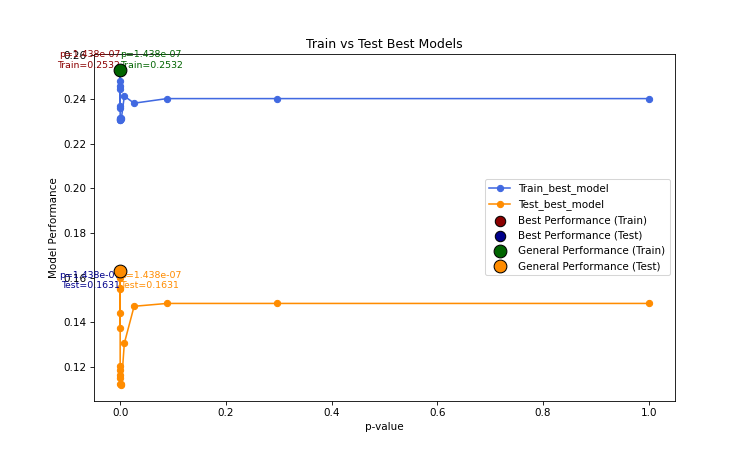

2. Reporting Generalized Performance:

|                  | 6                       |
|:-----------------|:------------------------|
| clump_p1         | 1.0                     |
| clump_r2         | 0.1                     |
| clump_kb         | 200.0                   |
| p_window_size    | 200.0                   |
| p_slide_size     | 50.0                    |
| p_LD_threshold   | 0.25                    |
| pvalue           | 1.438449888287663e-07   |
| numberofpca      | 6.0                     |
| tempalpha        | 0.1                     |
| l1weight         | 0.1                     |
| Train_pure_prs   | -1.871693838042532e-05  |
| Train_null_model | 0.23001030414198947     |
| Train_best_model | 0.25317209847328825     |
| Test_pure_prs    | -2.4250291105820666e-05 |
| Test_null_model  | 0.11869244971793831     |
| Test_best_model  | 0.16311009260205542     |
| genomic_built    | hg19                    |
| Difference       | 0.09006200587123284     |
| Sum              | 

<IPython.core.display.Javascript object>


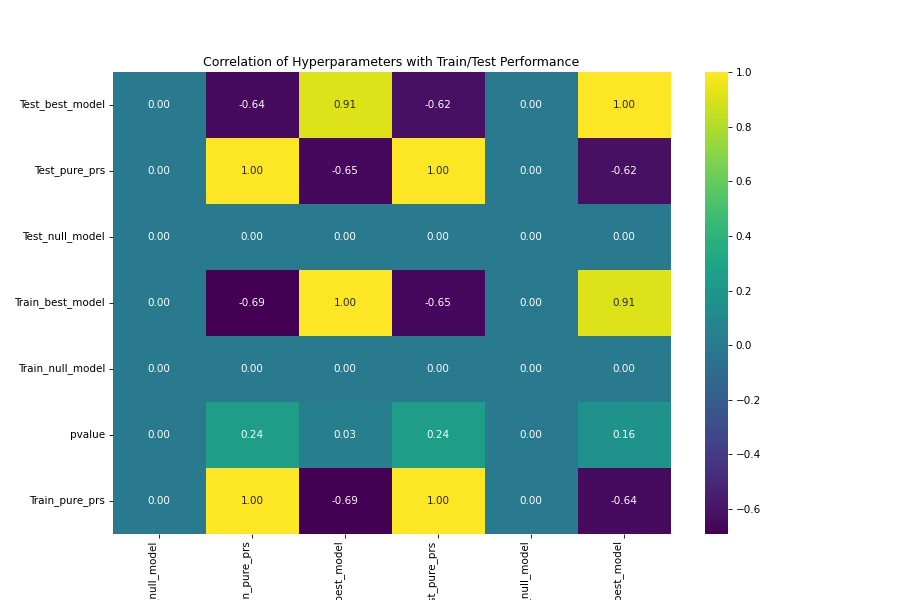

<IPython.core.display.Javascript object>


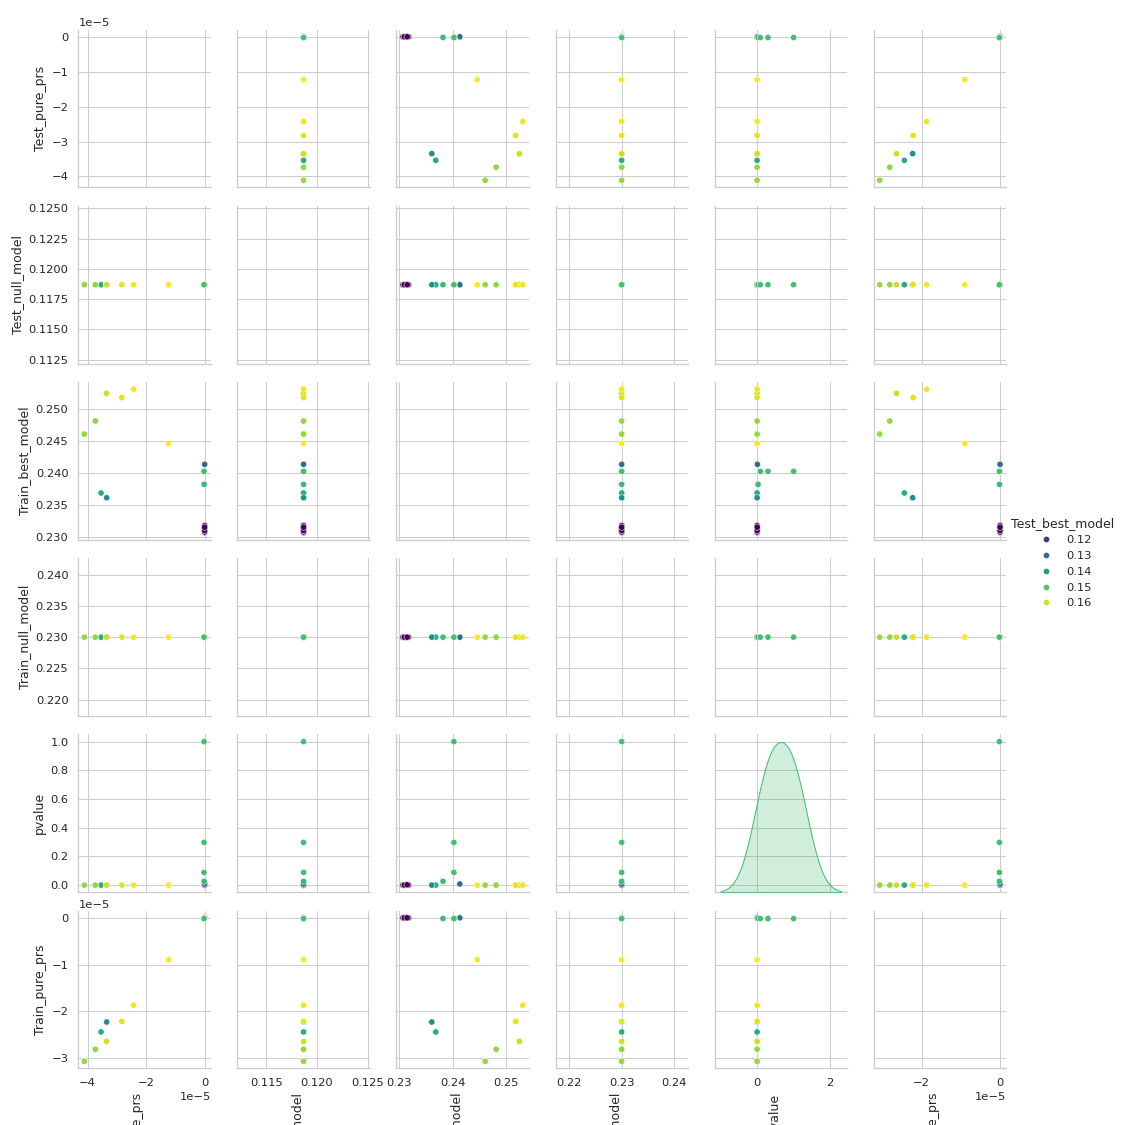

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib notebook

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

df = divided_result.sort_values(by='Train_best_model', ascending=False)
print("1. Reporting Based on Best Training Performance:\n")
print(df.iloc[0].to_markdown())


 
df = divided_result.copy()

# Plot Train and Test best models against p-values
plt.figure(figsize=(10, 6))
plt.plot(df['pvalue'], df['Train_best_model'], label='Train_best_model', marker='o', color='royalblue')
plt.plot(df['pvalue'], df['Test_best_model'], label='Test_best_model', marker='o', color='darkorange')

# Highlight the p-value where both train and test are high
best_index = df[['Train_best_model']].sum(axis=1).idxmax()
best_pvalue = df.loc[best_index, 'pvalue']
best_train = df.loc[best_index, 'Train_best_model']
best_test = df.loc[best_index, 'Test_best_model']

# Use dark colors for the circles
plt.scatter(best_pvalue, best_train, color='darkred', s=100, label=f'Best Performance (Train)', edgecolor='black', zorder=5)
plt.scatter(best_pvalue, best_test, color='darkblue', s=100, label=f'Best Performance (Test)', edgecolor='black', zorder=5)

# Annotate the best performance with p-value, train, and test values
plt.text(best_pvalue, best_train, f'p={best_pvalue:.4g}\nTrain={best_train:.4g}', ha='right', va='bottom', fontsize=9, color='darkred')
plt.text(best_pvalue, best_test, f'p={best_pvalue:.4g}\nTest={best_test:.4g}', ha='right', va='top', fontsize=9, color='darkblue')

# Calculate Difference and Sum
df['Difference'] = abs(df['Train_best_model'] - df['Test_best_model'])
df['Sum'] = df['Train_best_model'] + df['Test_best_model']

# Sort the DataFrame
sorted_df = df.sort_values(by=['Sum', 'Difference'], ascending=[False, True])
#sorted_df = df.sort_values(by=[ 'Difference','Sum'], ascending=[  True,False])

# Highlight the general performance
general_index = sorted_df.index[0]
general_pvalue = sorted_df.loc[general_index, 'pvalue']
general_train = sorted_df.loc[general_index, 'Train_best_model']
general_test = sorted_df.loc[general_index, 'Test_best_model']

plt.scatter(general_pvalue, general_train, color='darkgreen', s=150, label='General Performance (Train)', edgecolor='black', zorder=6)
plt.scatter(general_pvalue, general_test, color='darkorange', s=150, label='General Performance (Test)', edgecolor='black', zorder=6)

# Annotate the general performance with p-value, train, and test values
plt.text(general_pvalue, general_train, f'p={general_pvalue:.4g}\nTrain={general_train:.4g}', ha='left', va='bottom', fontsize=9, color='darkgreen')
plt.text(general_pvalue, general_test, f'p={general_pvalue:.4g}\nTest={general_test:.4g}', ha='left', va='top', fontsize=9, color='darkorange')

# Add labels and legend
plt.xlabel('p-value')
plt.ylabel('Model Performance')
plt.title('Train vs Test Best Models')
plt.legend()
plt.show()
 




print("2. Reporting Generalized Performance:\n")
df = divided_result.copy()
df['Difference'] = abs(df['Train_best_model'] - df['Test_best_model'])
df['Sum'] = df['Train_best_model'] + df['Test_best_model']
sorted_df = df.sort_values(by=['Sum', 'Difference'], ascending=[False, True])
print(sorted_df.iloc[0].to_markdown())


print("3. Reporting the correlation of hyperparameters and the performance of 'Train_null_model', 'Train_pure_prs', 'Train_best_model', 'Test_pure_prs', 'Test_null_model', and 'Test_best_model':\n")

print("3. For string hyperparameters, we used one-hot encoding to find the correlation between string hyperparameters and 'Train_null_model', 'Train_pure_prs', 'Train_best_model', 'Test_pure_prs', 'Test_null_model', and 'Test_best_model'.")

print("3. We performed this analysis for those hyperparameters that have more than one unique value.")

correlation_columns = [
 'Train_null_model', 'Train_pure_prs', 'Train_best_model',
 'Test_pure_prs', 'Test_null_model', 'Test_best_model'
]

hyperparams = [col for col in divided_result.columns if len(divided_result[col].unique()) > 1]
hyperparams = list(set(hyperparams+correlation_columns))
 
# Separate numeric and string columns
numeric_hyperparams = [col for col in hyperparams if pd.api.types.is_numeric_dtype(divided_result[col])]
string_hyperparams = [col for col in hyperparams if pd.api.types.is_string_dtype(divided_result[col])]


# Encode string columns using one-hot encoding
divided_result_encoded = pd.get_dummies(divided_result, columns=string_hyperparams)

# Combine numeric hyperparams with the new one-hot encoded columns
encoded_columns = [col for col in divided_result_encoded.columns if col.startswith(tuple(string_hyperparams))]
hyperparams = numeric_hyperparams + encoded_columns
 

# Calculate correlations
correlations = divided_result_encoded[hyperparams].corr()
 
# Display correlation of hyperparameters with train/test performance columns
hyperparam_correlations = correlations.loc[hyperparams, correlation_columns]
 
hyperparam_correlations = hyperparam_correlations.fillna(0)

# Plotting the correlation heatmap
plt.figure(figsize=(12, 8))
ax = sns.heatmap(hyperparam_correlations, annot=True, cmap='viridis', fmt='.2f', cbar=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')

# Rotate y-axis labels to horizontal
#ax.set_yticklabels(ax.get_yticklabels(), rotation=0, va='center')

plt.title('Correlation of Hyperparameters with Train/Test Performance')
plt.show() 

sns.set_theme(style="whitegrid")  # Choose your preferred style
pairplot = sns.pairplot(divided_result_encoded[hyperparams],hue = 'Test_best_model', palette='viridis')

# Adjust the figure size
pairplot.fig.set_size_inches(15, 15)  # You can adjust the size as needed

for ax in pairplot.axes.flatten():
    ax.set_xlabel(ax.get_xlabel(), rotation=90, ha='right')  # X-axis labels vertical
    #ax.set_ylabel(ax.get_ylabel(), rotation=0, va='bottom')  # Y-axis labels horizontal

# Show the plot
plt.show()


